In [6]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import caffe
import cv2
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [2]:
PATCH_SIZE = 227

WEIGHTS_FILE = '/home/jing/Documents/CNN_tabletennis/example_regression_iter_10000.caffemodel'
DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/regression_deploy.prototxt'
MEAN_FILE = '/home/jing/Documents/CNN_tabletennis/data/old/mean.npy'

In [3]:
mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 120.84302377   95.50270232  100.48351717]


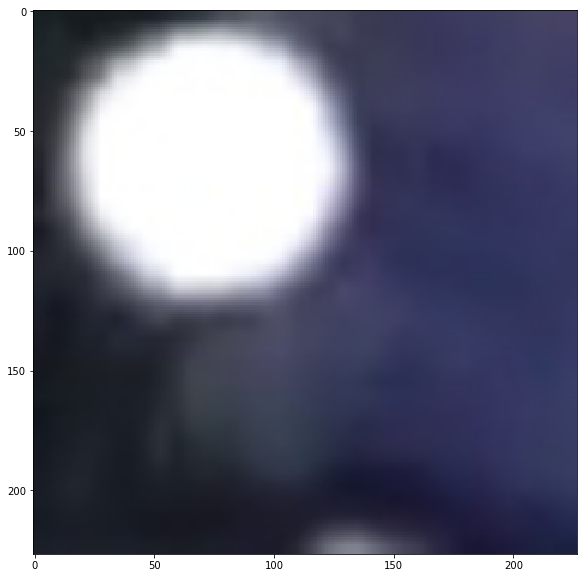

In [7]:
img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0014L028300.jpg'

#batch_size = net.blobs['data'].data.shape[0]

image = caffe.io.load_image(img_name)
image = cv2.resize(image, (PATCH_SIZE, PATCH_SIZE))
plt.imshow(image)

In [8]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

#class_pred = output['my_cls_score'][0]
#class_pred = output['my_fc8'][0]
bbox_pred = output['my_pred'][0]

bbox_pred[0] = 227*bbox_pred[0]+227.0/2
bbox_pred[1] = 227*bbox_pred[1]+227.0/2
bbox_pred[2] = 227*np.exp(bbox_pred[2])
bbox_pred[3] = 227*np.exp(bbox_pred[3])

#print 'predicted class is ', class_pred.argmax()
#print 'class score: ', class_pred
print 'bbox is ', bbox_pred

bbox is  [ 107.35997009  103.73042297  120.52734375  113.79000854]


In [9]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

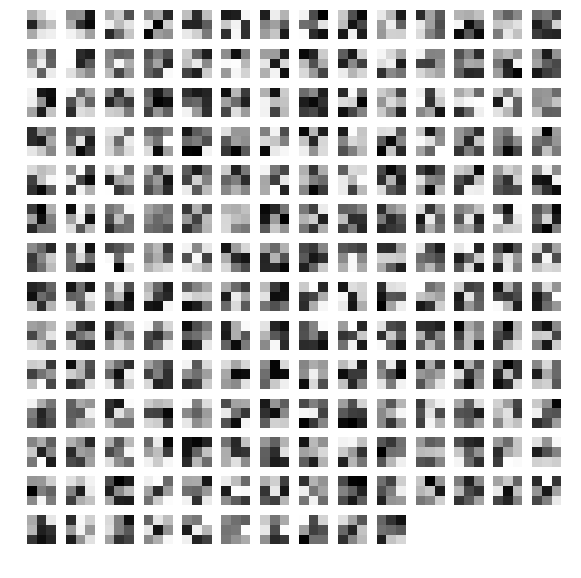

In [10]:
# the parameters are a list of [weights, biases]
#filters = net.params['conv1'][0].data
#vis_square(filters.transpose(0, 2, 3, 1))
filters = net.params['my_conv5'][0].data
vis_square(filters[1])
#print filters[4][3]

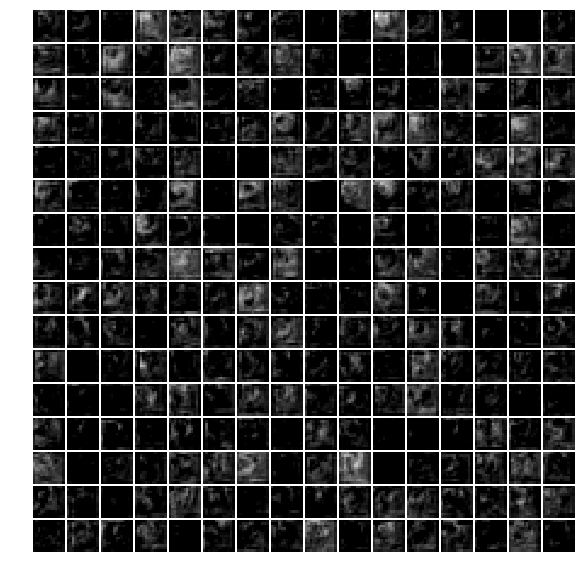

In [14]:
feat = net.blobs['my_conv5'].data[0]
vis_square(feat)

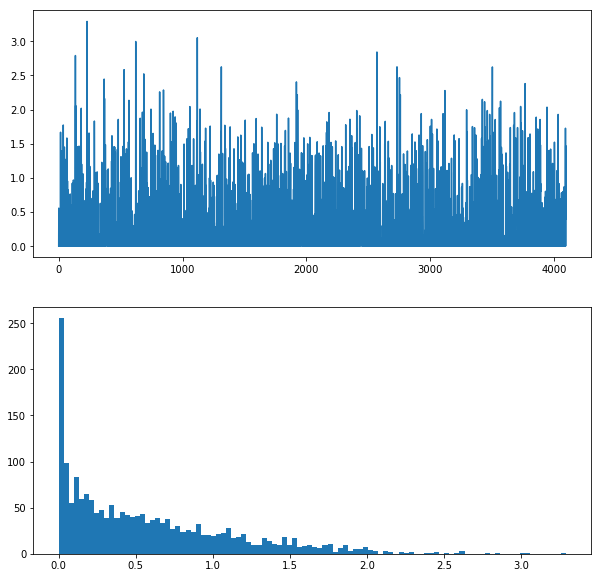

In [12]:
feat = net.blobs['reg_fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

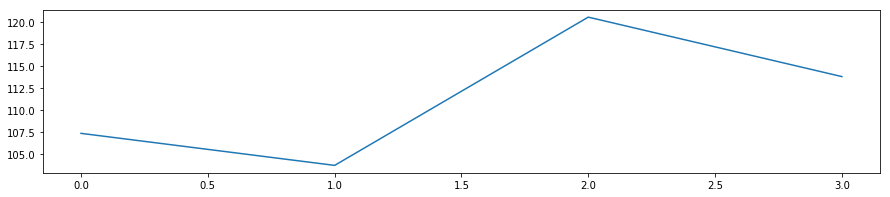

In [13]:
feat = net.blobs['my_pred'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)